# Dead reckoning- baseline

In [63]:
import numpy as np
import pandas as pd


from numba import jit

from ahrs.filters import Madgwick

from ahrs.common.orientation import acc2q

import matplotlib.pyplot as plt

import scipy


In [64]:
path = "./data/test_imu_B_2_1.csv"
imu_df = pd.read_csv(path)
imu_df.head(1)

,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature
0,35752794502900,440160,-9.7878,-0.1089,-0.5791,-0.1393,-0.1087,-0.0831,23.22


In [65]:
n = len(imu_df)
t = imu_df["arduino_timestamp"].values * 1e-3
a_s = imu_df[["ax", "ay", "az"]].values
g_s = imu_df[["gx", "gy", "gz"]].values

In [66]:
t


array([440.16 , 440.171, 440.183, ..., 489.306, 489.317, 489.328])

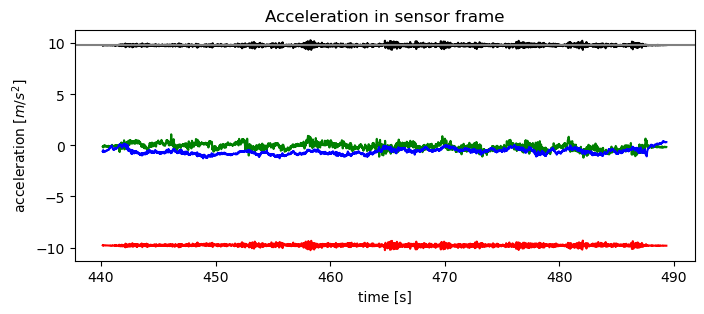

In [67]:
# Show acceleration in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, a_s[:, 0], c="r")
ax.plot(t, a_s[:, 1], c="g")
ax.plot(t, a_s[:, 2], c="b")
ax.plot(t, np.sqrt((a_s ** 2).sum(axis=-1)), c="k")
ax.axhline(9.81, c="gray")
ax.set_xlabel("time [s]")
ax.set_ylabel("acceleration $[m/s^2]$")
ax.set_title("Acceleration in sensor frame")
plt.show()

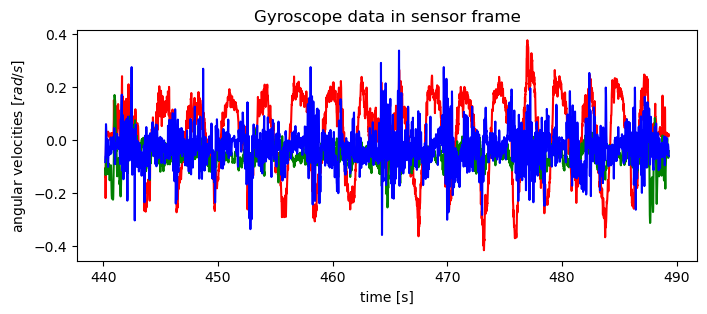

In [68]:
# Show gyroscope in sensor frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, g_s[:, 0], c="r")
ax.plot(t, g_s[:, 1], c="g")
ax.plot(t, g_s[:, 2], c="b")
ax.set_xlabel("time [s]")
ax.set_ylabel("angular velocities $[rad/s]$")
ax.set_title("Gyroscope data in sensor frame")
plt.show()

In [69]:
# Apply orientation filter
madgwick = Madgwick()
q_sn = np.zeros((n, 4))
q_sn[0] =  acc2q(a_s[0]) #[1,0,0,0] 
for i in range(1, n):
    madgwick.Dt = t[i] - t[i - 1] # needed because sample rate is not constant (yet)
    q_sn[i] = madgwick.updateIMU(q_sn[i - 1], g_s[i], a_s[i])

In [70]:
def conjugate(q):
    return q * np.array([1.0, -1.0, -1.0, -1.0])[..., :]

def rotation_matrix(q):
    w = q[..., 0]
    x = q[..., 1]
    y = q[..., 2]
    z = q[..., 3]
    R = np.zeros((*q.shape[:-1], 3, 3), dtype=q.dtype)
    R[..., 0, 0] = 1 - 2 * (y * y + z * z)
    R[..., 0, 1] = 2 * (x * y - z * w)
    R[..., 0, 2] = 2 * (x * z + y * w)
    R[..., 1, 0] = 2 * (x * y + z * w)
    R[..., 1, 1] = 1 - 2 * (x * x + z * z)
    R[..., 1, 2] = 2 * (y * z - x * w)
    R[..., 2, 0] = 2 * (x * z - y * w)
    R[..., 2, 1] = 2 * (y * z + x * w)
    R[..., 2, 2] = 1 - 2 * (x * x + y * y)
    return R

In [71]:
# Get associated rotation matrix, with homogeneous coordinate
R_sn = rotation_matrix(q_sn)


In [72]:
# Get measured acceleration in navigation frame
a_n = (R_sn @ a_s[:, :, None]).squeeze(-1)

In [73]:
# It seems that our calibration could be better...
np.median(np.sqrt((a_n ** 2).sum(axis=-1)))

9.81302386244138

In [74]:
# Let us use this as "Earth gravity"
EARTH_GRAVITY = 9.81 # 10.0

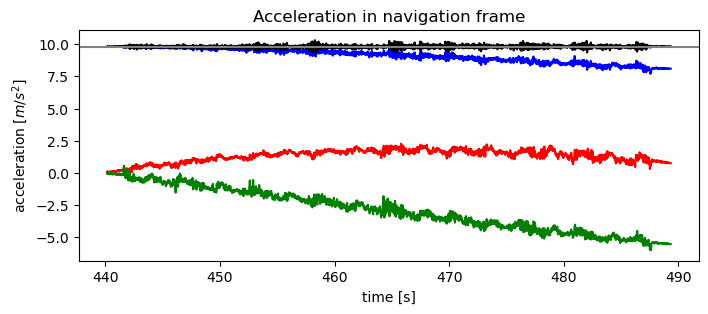

In [75]:
# Show acceleration in navigation frame
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, a_n[:, 0], c="r")
ax.plot(t, a_n[:, 1], c="g")
ax.plot(t, a_n[:, 2], c="b")
ax.plot(t, np.sqrt((a_n ** 2).sum(axis=-1)), c="k")
ax.axhline(EARTH_GRAVITY, c="gray")
ax.set_xlabel("time [s]")
ax.set_ylabel("acceleration $[m/s^2]$")
ax.set_title("Acceleration in navigation frame")
plt.show()

In [76]:
a_n_with_gravity = a_n.copy()

# subtstract gravity
a_n[:, 2] = a_n[:, 2] - EARTH_GRAVITY

In [77]:
@jit(nopython=True)
def integrate_1d(t, dx, x0=0):
    assert t.shape == dx.shape
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = t[i] - t[i - 1]
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
    return x

def integrate(t, dx):
    _, depth = dx.shape
    x = np.empty_like(dx)
    for d in range(depth):
        x[:, d] = integrate_1d(t, dx[:, d])
    return x

In [78]:
# Integrate acceleration to get velocity
v_n = integrate(t, a_n)



In [79]:
# Integrate velocity to get position
p_n = integrate(t, v_n) #v_filtered_n


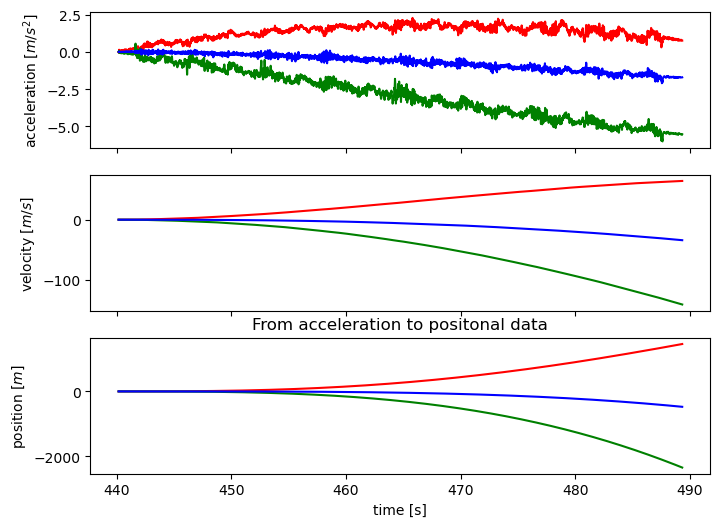

In [80]:
# Show final result
_, axes = plt.subplots(3, sharex=True, figsize=(8, 6))
axes[0].plot(t, a_n[:, 0], c="r")
axes[0].plot(t, a_n[:, 1], c="g")
axes[0].plot(t, a_n[:, 2], c="b")
axes[0].set_ylabel("acceleration $[m/s^2]$")
axes[1].plot(t, v_n[:, 0], c="r")
axes[1].plot(t, v_n[:, 1], c="g")
axes[1].plot(t, v_n[:, 2], c="b")
axes[1].set_ylabel("velocity $[m/s]$")
axes[2].plot(t, p_n[:, 0], c="r")
axes[2].plot(t, p_n[:, 1], c="g")
axes[2].plot(t, p_n[:, 2], c="b")
axes[2].set_ylabel("position $[m]$")
axes[-1].set_xlabel("time [s]")
plt.title("From acceleration to positonal data")
plt.show()

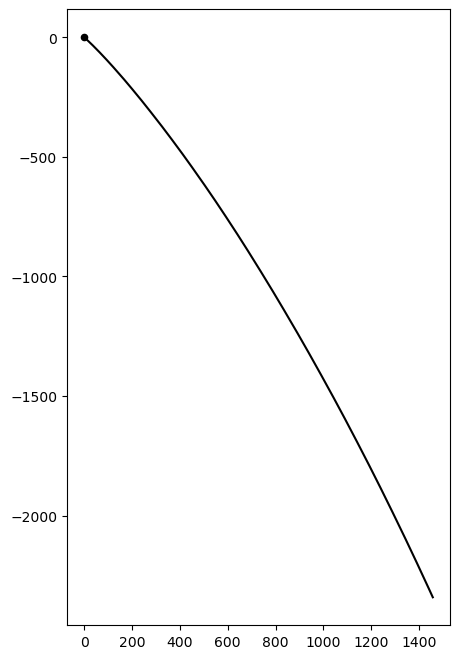

In [81]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(p_n[:, 0], p_n[:, 1], c="k")
ax.scatter(p_n[0, 0], p_n[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

## Extand basline with filtering (Butterworth)

In [82]:
# filter velocity

sample_rate = 1.0 / np.mean(np.diff(t))
cutoff = 0.1 # 0.1 # 0.15
b, a = scipy.signal.butter(6, cutoff, "highpass", fs=sample_rate) #5

def highpass_filter(x):
    return scipy.signal.filtfilt(b, a, x, axis=0)

v_filtered_n = highpass_filter(v_n)

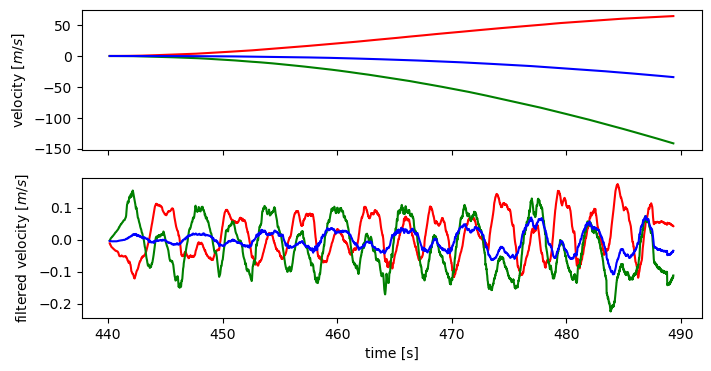

In [83]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, v_n[:, 0], c="r")
axes[0].plot(t, v_n[:, 1], c="g")
axes[0].plot(t, v_n[:, 2], c="b")
axes[0].set_ylabel("velocity $[m/s]$")
axes[1].plot(t, v_filtered_n[:, 0], c="r")
axes[1].plot(t, v_filtered_n[:, 1], c="g")
axes[1].plot(t, v_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered velocity $[m/s]$")
axes[-1].set_xlabel("time [s]")
plt.savefig("filtered_velocity.png")
plt.show()

In [84]:
# Integrate velocity to get position
p_n = integrate(t, v_filtered_n)

In [85]:
p_filtered_n = highpass_filter(p_n)

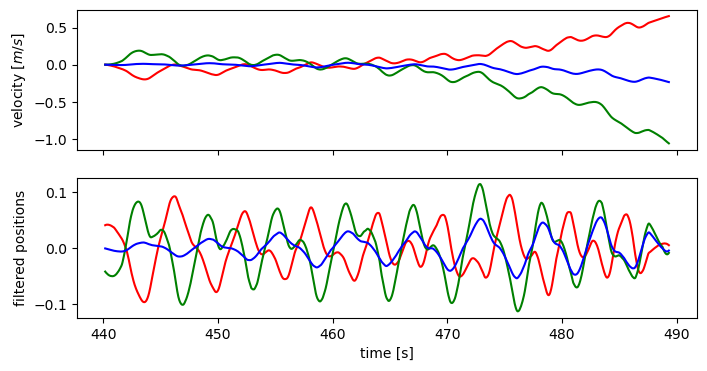

In [86]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, p_n[:, 0], c="r")
axes[0].plot(t, p_n[:, 1], c="g")
axes[0].plot(t, p_n[:, 2], c="b")
axes[0].set_ylabel("velocity $[m/s]$")
axes[1].plot(t, p_filtered_n[:, 0], c="r")
axes[1].plot(t, p_filtered_n[:, 1], c="g")
axes[1].plot(t, p_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered positions")
axes[-1].set_xlabel("time [s]")
plt.show()

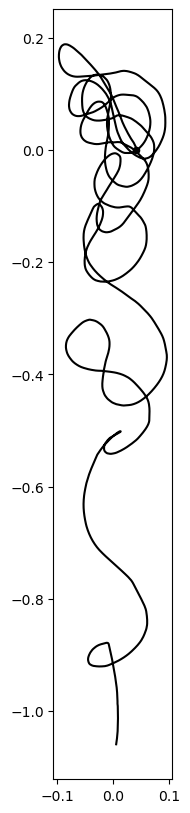

In [87]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(10,10))
ax.plot(p_filtered_n[:, 0], p_n[:, 1], c="k")
ax.scatter(p_filtered_n[0, 0], p_n[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

It is clearly observable how over time we diverge from the actual trace/shape of the motion.

## Try Chebyshev Type I filter


In [88]:
from scipy.signal import cheby1, filtfilt

# Define the filter parameters
order = 4  # Filter order
cutoff = 0.1  # Cut-off frequency
ripple = 0.1  # Maximum passband ripple in dB

# Normalize the cut-off frequency
nyquist_freq = 0.5 * sample_rate
normalized_cutoff = cutoff / nyquist_freq

# Design the Chebyshev Type I filter
b, a = cheby1(order, ripple, normalized_cutoff, btype='high', analog=False, output='ba')

# Apply the filter to the velocity data
v_filtered_n = filtfilt(b, a, v_n, axis=0)

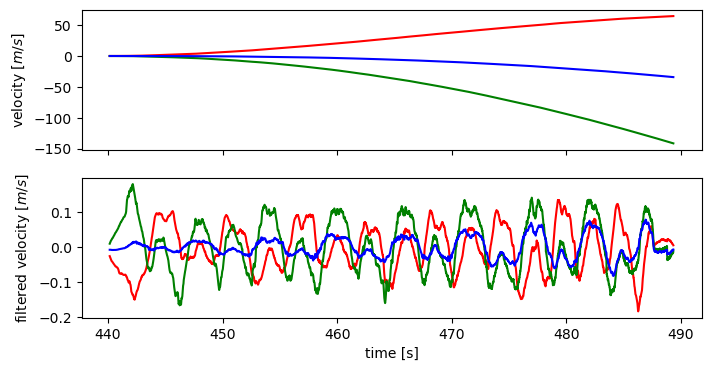

In [89]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, v_n[:, 0], c="r")
axes[0].plot(t, v_n[:, 1], c="g")
axes[0].plot(t, v_n[:, 2], c="b")
axes[0].set_ylabel("velocity $[m/s]$")
axes[1].plot(t, v_filtered_n[:, 0], c="r")
axes[1].plot(t, v_filtered_n[:, 1], c="g")
axes[1].plot(t, v_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered velocity $[m/s]$")
axes[-1].set_xlabel("time [s]")
plt.savefig("filtered_velocity.png")
plt.show()

In [90]:
# Integrate velocity to get position
p_n = integrate(t, v_filtered_n)

In [91]:
p_filtered_n = filtfilt(b, a, p_n, axis=0)

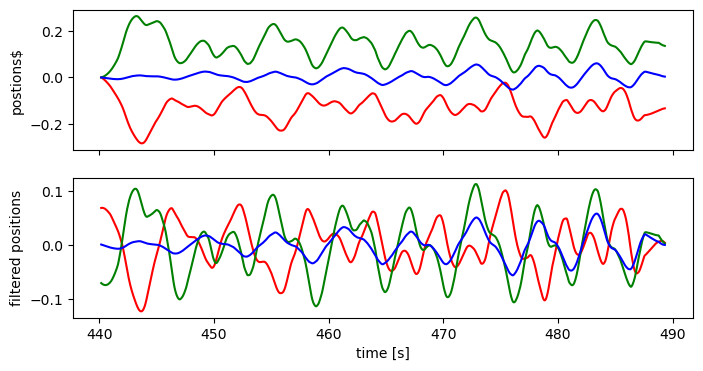

In [92]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, p_n[:, 0], c="r")
axes[0].plot(t, p_n[:, 1], c="g")
axes[0].plot(t, p_n[:, 2], c="b")
axes[0].set_ylabel("postions$")
axes[1].plot(t, p_filtered_n[:, 0], c="r")
axes[1].plot(t, p_filtered_n[:, 1], c="g")
axes[1].plot(t, p_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered positions")
axes[-1].set_xlabel("time [s]")
plt.show()

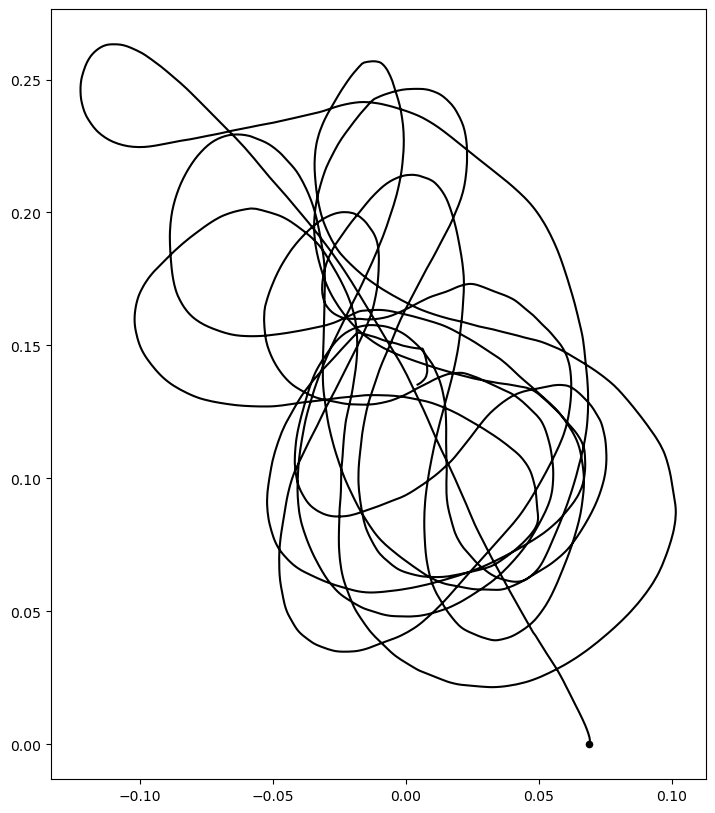

In [93]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(10,10))
ax.plot(p_filtered_n[:, 0], p_n[:, 1], c="k")
ax.scatter(p_filtered_n[0, 0], p_n[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

## Try Chebyshev Type 2 filter

In [94]:
# Define the filter specifications
order = 6  # Filter order
ripple = 0.1  # Maximum ripple attenuation in the passband (in dB)
stop_attenuation = 20  # Minimum attenuation in the stopband (in dB)
cutoff_freq = 0.1  # Cutoff frequency (normalized)

# Convert ripple and stop_attenuation from dB to linear scale
ripple_linear = 10 ** (-ripple / 20)
stop_attenuation_linear = 10 ** (-stop_attenuation / 20)

# Calculate the normalized cutoff frequency
nyquist_freq = 20  # Nyquist frequency (normalized)
normalized_cutoff_freq = cutoff_freq / nyquist_freq

# Design the Chebyshev Type II filter
b, a = scipy.signal.cheby2(order, stop_attenuation, normalized_cutoff_freq, btype='high', analog=False, output='ba')

# Apply the filter to the velocity signal
v_filtered_n = scipy.signal.filtfilt(b, a, v_n, axis=0)

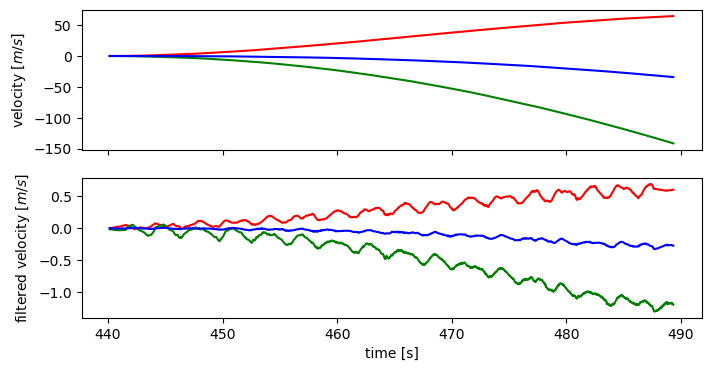

In [95]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, v_n[:, 0], c="r")
axes[0].plot(t, v_n[:, 1], c="g")
axes[0].plot(t, v_n[:, 2], c="b")
axes[0].set_ylabel("velocity $[m/s]$")
axes[1].plot(t, v_filtered_n[:, 0], c="r")
axes[1].plot(t, v_filtered_n[:, 1], c="g")
axes[1].plot(t, v_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered velocity $[m/s]$")
axes[-1].set_xlabel("time [s]")
plt.savefig("filtered_velocity.png")
plt.show()

In [96]:
# Integrate velocity to get position
p_n = integrate(t, v_filtered_n)

In [97]:
p_filtered_n = filtfilt(b, a, p_n, axis=0)

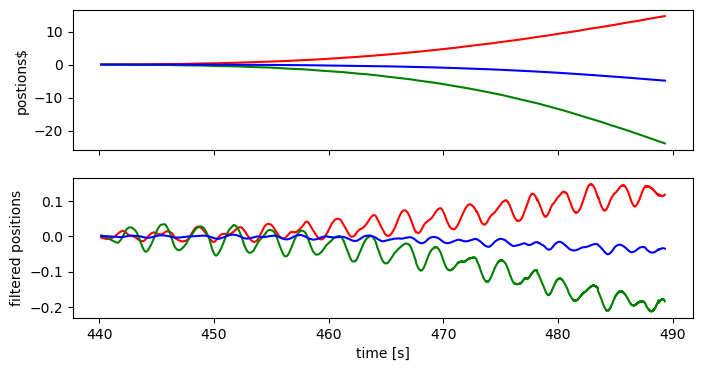

In [98]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, p_n[:, 0], c="r")
axes[0].plot(t, p_n[:, 1], c="g")
axes[0].plot(t, p_n[:, 2], c="b")
axes[0].set_ylabel("postions$")
axes[1].plot(t, p_filtered_n[:, 0], c="r")
axes[1].plot(t, p_filtered_n[:, 1], c="g")
axes[1].plot(t, p_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered positions")
axes[-1].set_xlabel("time [s]")
plt.show()

## Try Elliptic filter

In [99]:
import numpy as np
import scipy.signal

# Filter parameters
order = 4
ripple = 0.1  # Maximum ripple attenuation in the passband (in dB)
stop_attenuation = 20  # Minimum attenuation in the stopband (in dB)
normalized_cutoff = 0.2  # Cutoff frequency (normalized, between 0 and 1)

# Design elliptic filter
b, a = scipy.signal.ellip(order, ripple, stop_attenuation, normalized_cutoff, btype='high', analog=False, output='ba')

# Apply the filter to your data
v_filtered_n = scipy.signal.filtfilt(b, a, v_n, axis=0)

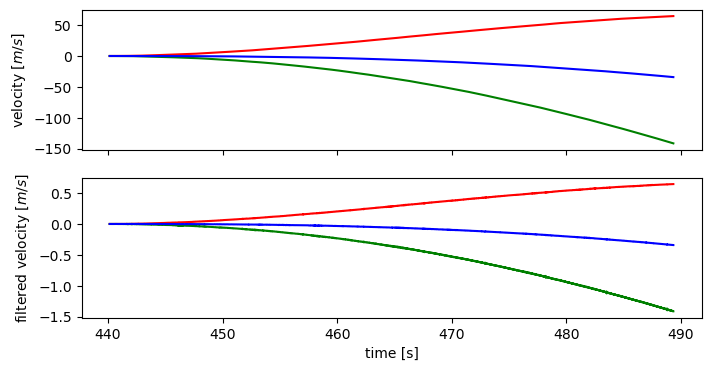

In [100]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, v_n[:, 0], c="r")
axes[0].plot(t, v_n[:, 1], c="g")
axes[0].plot(t, v_n[:, 2], c="b")
axes[0].set_ylabel("velocity $[m/s]$")
axes[1].plot(t, v_filtered_n[:, 0], c="r")
axes[1].plot(t, v_filtered_n[:, 1], c="g")
axes[1].plot(t, v_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered velocity $[m/s]$")
axes[-1].set_xlabel("time [s]")
plt.savefig("filtered_velocity.png")
plt.show()

In [101]:
# Integrate velocity to get position
p_n = integrate(t, v_filtered_n)

In [102]:
p_filtered_n = filtfilt(b, a, p_n, axis=0)

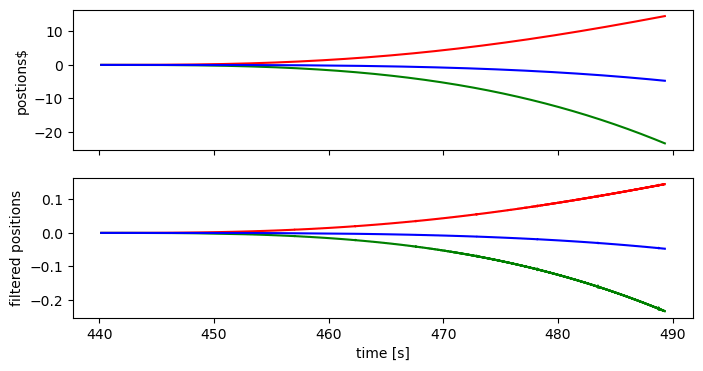

In [103]:
# Show comparison before and after highpass filter on velocity
_, axes = plt.subplots(2, sharex=True, figsize=(8, 4))
axes[0].plot(t, p_n[:, 0], c="r")
axes[0].plot(t, p_n[:, 1], c="g")
axes[0].plot(t, p_n[:, 2], c="b")
axes[0].set_ylabel("postions$")
axes[1].plot(t, p_filtered_n[:, 0], c="r")
axes[1].plot(t, p_filtered_n[:, 1], c="g")
axes[1].plot(t, p_filtered_n[:, 2], c="b")
axes[1].set_ylabel("filtered positions")
axes[-1].set_xlabel("time [s]")
plt.show()

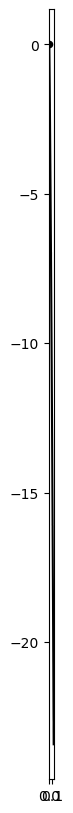

In [104]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(10,10))
ax.plot(p_filtered_n[:, 0], p_n[:, 1], c="k")
ax.scatter(p_filtered_n[0, 0], p_n[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()

### Use orientation filter twice to correct first estimation of navigation frame

In [115]:
# Apply orientation filter
madgwick = Madgwick()
q_sn = np.zeros((n, 4))
q_sn[0] =  acc2q(a_n_with_gravity[0]) #[1,0,0,0] 
for i in range(1, n):
    madgwick.Dt = t[i] - t[i - 1] # needed because sample rate is not constant (yet)
    q_sn[i] = madgwick.updateIMU(q_sn[i - 1], g_s[i], a_n_with_gravity[i])

In [116]:
# Get associated rotation matrix, with homogeneous coordinate
R_sn = rotation_matrix(q_sn)

In [117]:
# Get measured acceleration in navigation frame
a_n_2 = (R_sn @ a_n_with_gravity[:, :, None]).squeeze(-1)

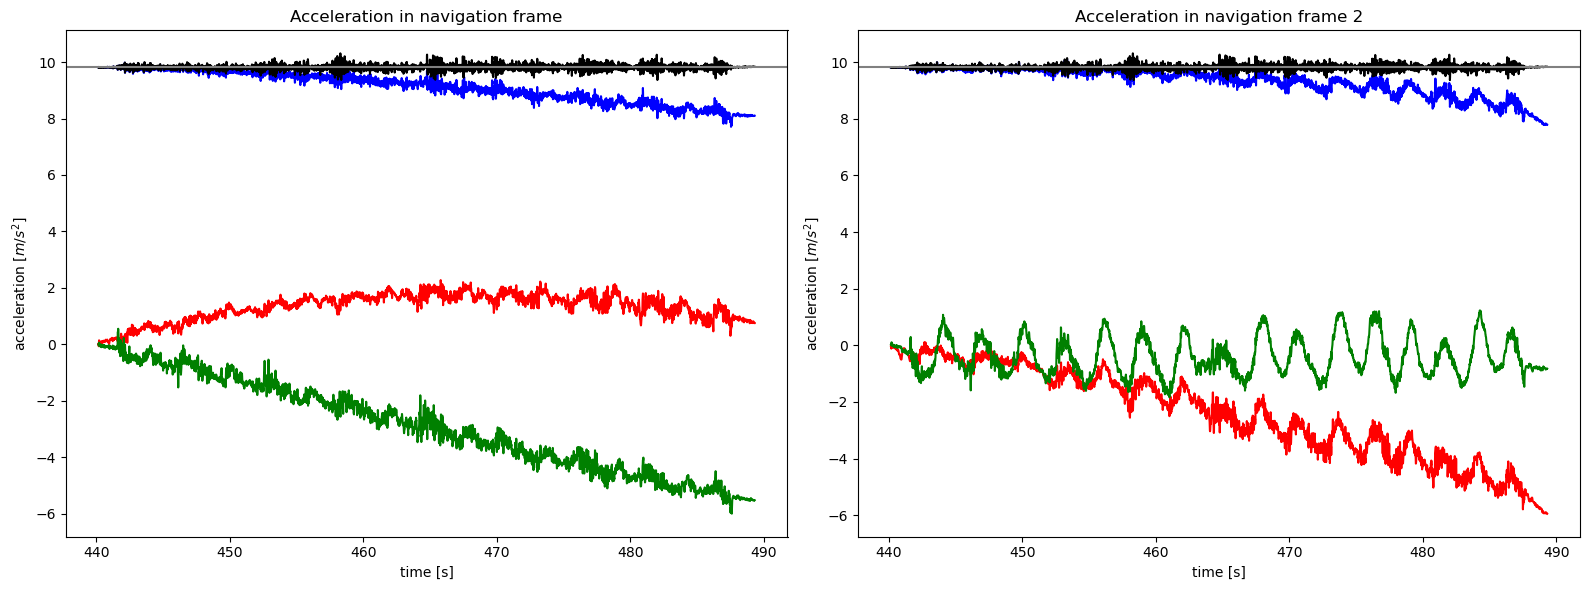

In [118]:
# Show acceleration in navigation frame

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1
axes[0].plot(t, a_n_with_gravity[:, 0], c="r")
axes[0].plot(t, a_n_with_gravity[:, 1], c="g")
axes[0].plot(t, a_n_with_gravity[:, 2], c="b")
axes[0].plot(t, np.sqrt((a_n_with_gravity ** 2).sum(axis=-1)), c="k")
axes[0].axhline(EARTH_GRAVITY, c="gray")
axes[0].set_xlabel("time [s]")
axes[0].set_ylabel("acceleration $[m/s^2]$")
axes[0].set_title("Acceleration in navigation frame")

# Plot 2 
axes[1].plot(t, a_n_2[:, 0], c="r")
axes[1].plot(t, a_n_2[:, 1], c="g")
axes[1].plot(t, a_n_2[:, 2], c="b")
axes[1].plot(t, np.sqrt((a_n_2 ** 2).sum(axis=-1)), c="k")
axes[1].axhline(EARTH_GRAVITY, c="gray")
axes[1].set_xlabel("time [s]")
axes[1].set_ylabel("acceleration $[m/s^2]$")
axes[1].set_title("Acceleration in navigation frame 2")

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [119]:
a_n_2[:,2] = a_n_2[:,2] - EARTH_GRAVITY

In [120]:
# Integrate acceleration to get velocity
v_n_2 = integrate(t, a_n_2)

In [121]:

sample_rate = 1.0 / np.mean(np.diff(t))
cutoff = 0.1 # 0.1 # 0.15
b, a = scipy.signal.butter(6, cutoff, "highpass", fs=sample_rate) #5

def highpass_filter(x):
    return scipy.signal.filtfilt(b, a, x, axis=0)

v_filtered_n = highpass_filter(v_n)

In [122]:
v_n_2 = highpass_filter(v_n_2)

In [123]:
# Integrate acceleration to get postional data
p_n_2 = integrate(t, v_n_2)

In [124]:
p_n_2 = highpass_filter(p_n_2)

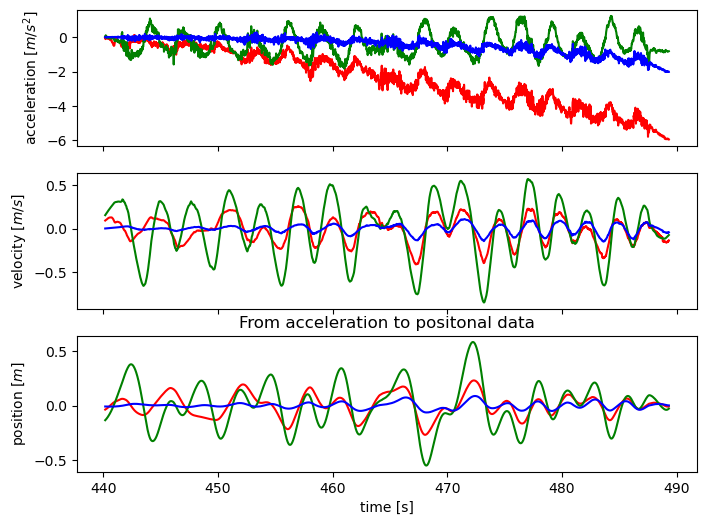

In [125]:
# Show final result
_, axes = plt.subplots(3, sharex=True, figsize=(8, 6))
axes[0].plot(t, a_n_2[:, 0], c="r")
axes[0].plot(t, a_n_2[:, 1], c="g")
axes[0].plot(t, a_n_2[:, 2], c="b")
axes[0].set_ylabel("acceleration $[m/s^2]$")
axes[1].plot(t, v_n_2[:, 0], c="r")
axes[1].plot(t, v_n_2[:, 1], c="g")
axes[1].plot(t, v_n_2[:, 2], c="b")
axes[1].set_ylabel("velocity $[m/s]$")
axes[2].plot(t, p_n_2[:, 0], c="r")
axes[2].plot(t, p_n_2[:, 1], c="g")
axes[2].plot(t, p_n_2[:, 2], c="b")
axes[2].set_ylabel("position $[m]$")
axes[-1].set_xlabel("time [s]")
plt.title("From acceleration to positonal data")
plt.show()

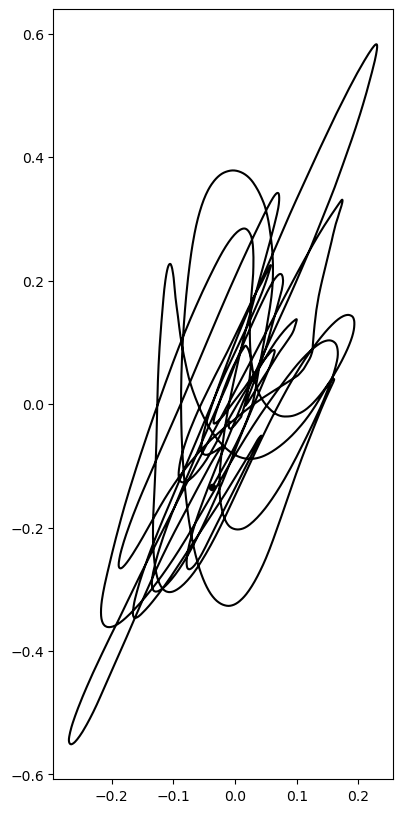

In [127]:
# Show position in horizontal plane
_, ax = plt.subplots(figsize=(10,10))
ax.plot(p_n_2[:, 0], p_n_2[:, 1], c="k")
ax.scatter(p_n_2[0, 0], p_n_2[0, 1], c="k", s=20)
ax.set_aspect("equal")
plt.show()